In [1]:
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.pmag as pmag

from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

/Users/lukefairchild765/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Dec: 355.5  Inc: 28.6
Number of directions in mean (n): 30
Angular radius of 95% confidence (a_95): 5.4
Precision parameter (k) estimate: 24.3


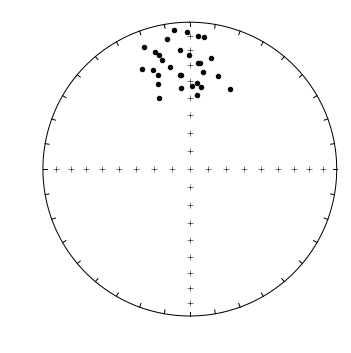

In [2]:
fisher_directions = ipmag.fishrot(k=20, n=30, dec=0, inc=30)
fisher_directions_mean = ipmag.fisher_mean(di_block=fisher_directions)
ipmag.print_direction_mean(fisher_directions_mean)
plt.figure(figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(di_block=fisher_directions)

In [3]:
directions = pd.DataFrame(fisher_directions,columns=['dec','inc','length'])
declinations = directions.dec.tolist()
inclinations = directions.inc.tolist()

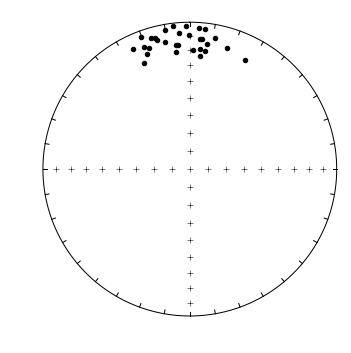

In [4]:
# squish all inclinations
squished_incs = []
for inclination in inclinations:
    squished_incs.append(ipmag.squish(inclination, 0.4))

# plot the squished directional data
plt.figure(num=1,figsize=(5,5))
ipmag.plot_net(1)
ipmag.plot_di(declinations,squished_incs)
squished_DIs = np.array(zip(declinations,squished_incs))

{'Dec': 355.48814588708694,
 'Inc': 28.628791300484835,
 'Me': 1.0311181327936323,
 'Me_critical': 1.094,
 'Mode': 'Mode 1',
 'Mu': 0.61146269567646538,
 'Mu_critical': 1.207,
 'N': 30,
 'Test_result': 'consistent with Fisherian model'}

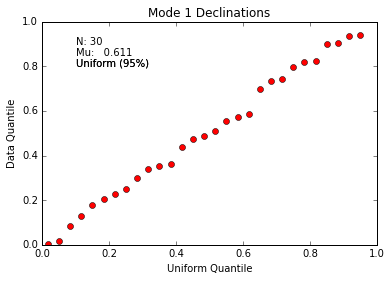

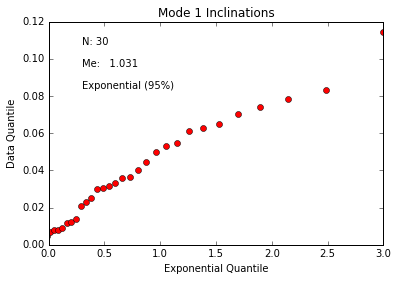

In [5]:
fish_test = ipmag.fishqq(declinations, inclinations)
fish_test

you need N> 10 for at least one mode
you need N> 10 for at least one mode
you need N> 10 for at least one mode
you need N> 10 for at least one mode
you need N> 10 for at least one mode
you need N> 10 for at least one mode
you need N> 10 for at least one mode
you need N> 10 for at least one mode


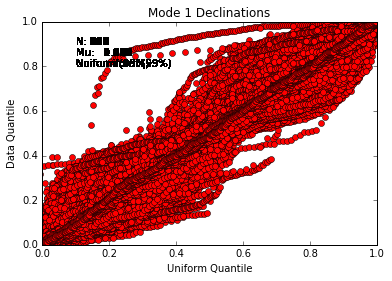

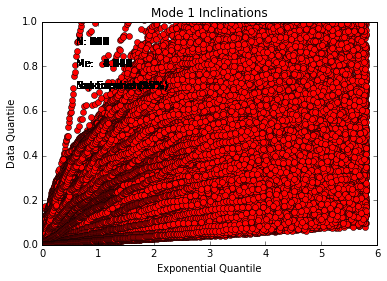

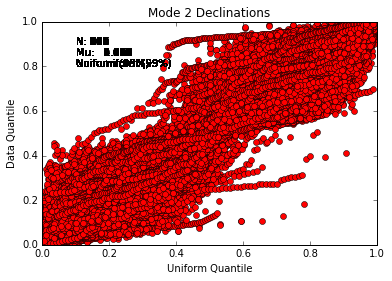

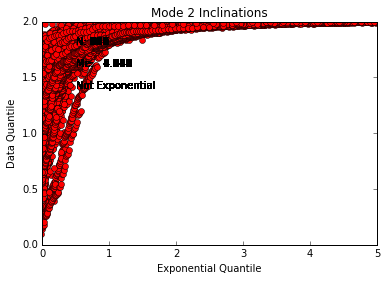

In [6]:
#%pdb

test_table = pd.DataFrame(columns=['N', 'f', 'Fisher', 'kappa'])

# k range = 5-80 ??? maybe should further randomize this based on resultant a95
b = 0
iterator = 0
nb = 1000

while b < nb:
    for flat in np.arange(0.1, 1, 0.1):
        kappa = np.random.choice(np.arange(5,80,5))
#         k=20
        n = np.random.randint(11, 500)
        decs, incs = ipmag.fishrot(k=kappa, n=n, di_block=False)
        squished_incs = ipmag.squish(incs, flat)
        try:
            fisher_test = ipmag.fishqq(decs, squished_incs)
        except:
            decs, squished_incs
        try:
            if fisher_test['Test_result'] == 'Fisherian model rejected':
                passed = False
            elif fisher_test['Test_result'] == 'consistent with Fisherian model':
                passed = True
        except TypeError: # returned two modes (not unimodal Fisher distribution)
            passed = False
        test_table.loc[iterator,['N', 'f', 'Fisher', 'kappa']] = [n, flat, passed, kappa]
        iterator += 1
    b += 1

In [7]:
test_table.head()

,N,f,Fisher,kappa
0,404,0.1,False,70
1,274,0.2,False,25
2,226,0.3,False,55
3,64,0.4,False,65
4,199,0.5,False,15


In [8]:
test_table = test_table.sort_values(by='kappa')
test_table = test_table.reset_index(drop=True)
test_table.head(20)

,N,f,Fisher,kappa
0,16,0.1,False,5
1,64,0.2,False,5
2,141,0.9,True,5
3,122,0.2,False,5
4,391,0.4,False,5
5,479,0.9,True,5
6,134,0.4,False,5
7,354,0.2,False,5
8,243,0.8,True,5
9,378,0.7,False,5


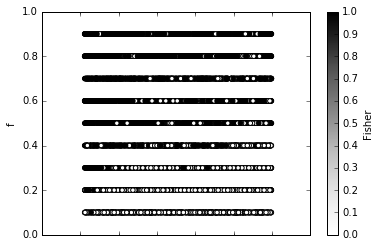

In [9]:
# line separating the True and False datapoints 
# should give the necessary number of samples per site 
# needed for a proper unflattening correction
test_table.plot.scatter('N', 'f', c='Fisher')
plt.show()

In [10]:
test_fail = test_table.loc[test_table['Fisher']==False]
test_pass = test_table.loc[test_table['Fisher']==True]

The primary objective of having a requisite N for a particular site is to make sure we can reliably distinguish between Fisher distributed data that has been squished and those that have not. 

Below we compare a scatterplot of correctly interpretted distributions of a particular N and flattening factor f (correctly interpretted = not consistent with Fisher distribution, as these are squished directions)

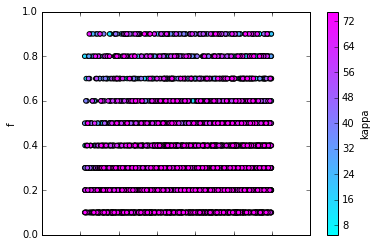

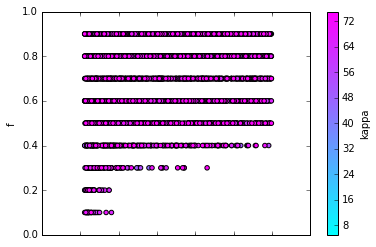

In [11]:
test_fail.plot.scatter('N', 'f', c='kappa', colormap='cool')
test_pass.plot.scatter('N', 'f', c='kappa',colormap='cool')

So if flattening factor is calculated by find_EI to be approx. 0.2, it looks like about 75 samples would be required for confidence in the correction ($\kappa = 45$). The requisite number of samples apparently increases exponentially with flattening factor (meaning it increases exponentially with the inverse of the degree of flattening). As N goes up, although you can be more confident in your correction, the massive flood of datapoints is more easily mistaken for a Fisher distribution (unless you squish it severely). This all also has dependence on k of course (it is a free variable in reality, although a single value is chosen above).

Interestingly, the lower the concentration parameter k (higher dispersal), the fewer samples are needed to reliably distinguish between an original Fisher distribution and a squished one. 

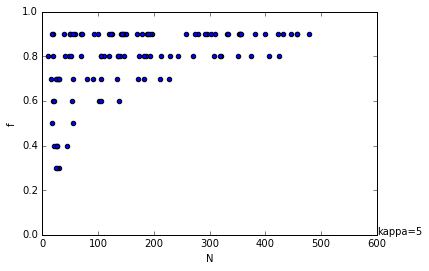

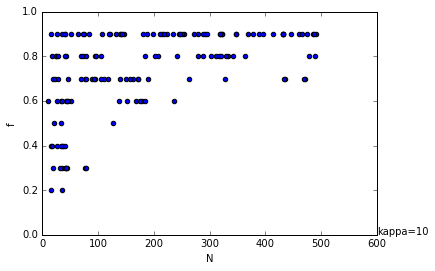

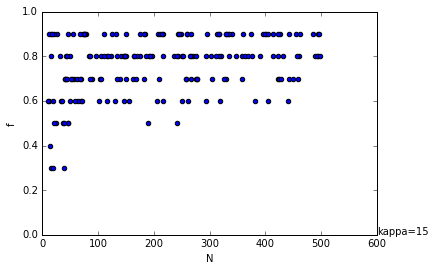

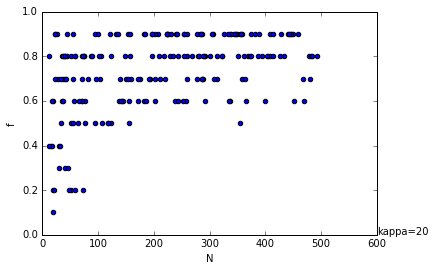

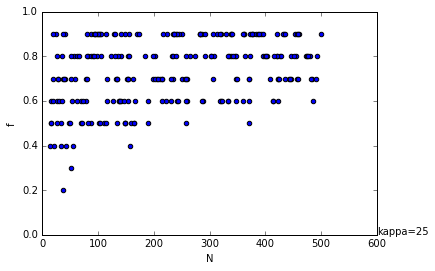

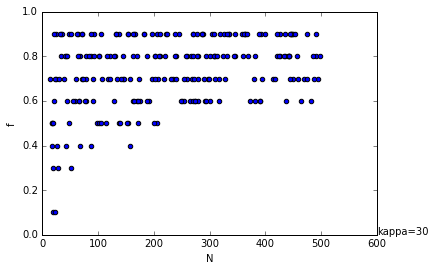

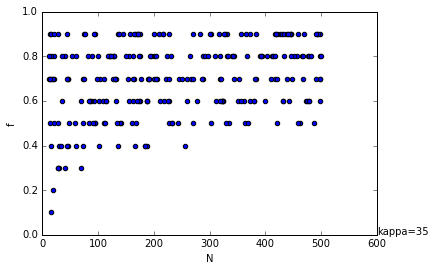

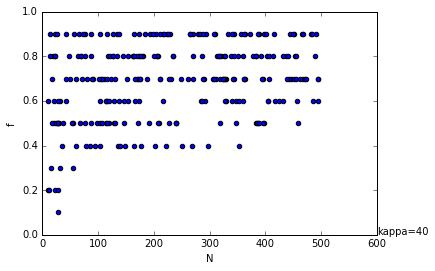

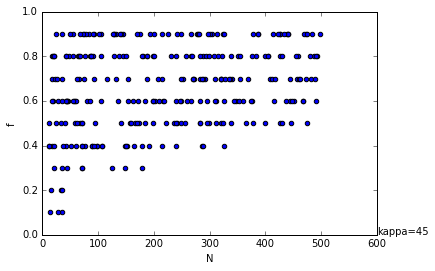

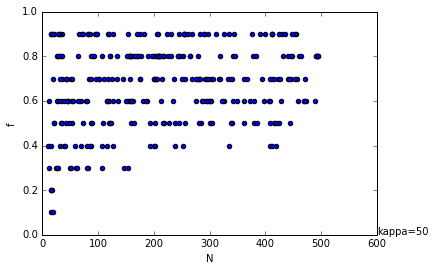

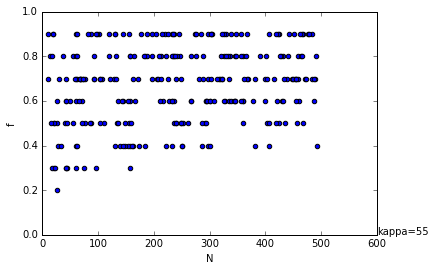

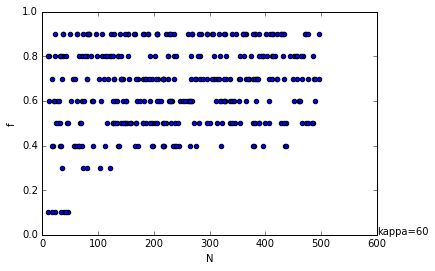

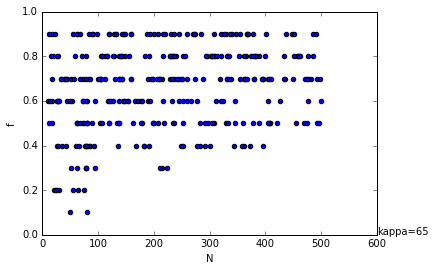

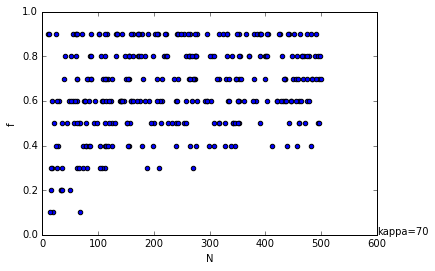

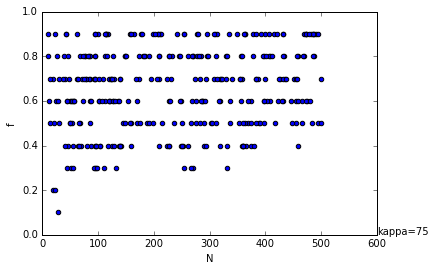

In [15]:
pass_dict = {}

for x in np.arange(5, 80, 5):
    pass_dict['test_pass_k{0}'.format(x)] = test_pass.loc[test_pass['kappa']==x]
    
for x in np.arange(5, 80, 5):
    pass_dict['test_pass_k{0}'.format(x)].plot.scatter('N', 'f', xlim=(0,600), ylim=(0.0,1.0))
    plt.text(1,0,'kappa=' + str(x), transform=plt.gca().transAxes)

In [13]:
test_pass.plot

55

In [14]:
for x in np.arange(0.1, 1, 0.05):
    new_df = test_table.loc[test_table['Fisher']==False]